# Image segmentation using segment seeds - the watershed algorithm

The watershed algorithm of image segmentation is used when we have initial segmented points and want to automatically fill surrounding areas with the same segmentation class. These initial segmented points are called seeds, and they should be set manually, but in some cases, it's possible to automatically assign them. This recipe shows how to implement the watershed segmentation algorithm in OpenCV.

The `cv2.watershed` function implements the algorithm and takes two arguments, the image to segment and the initial seeds. The segmented image should be color and `8-bit`. Seeds should be stored in the image, with the same spatial size as the segmented image, but with only one channel and a different depth, `int32`. Different seeds should be represented in the second argument, with different numbers, and other pixels should be set to zero. The routine fills zero values in the seed image with relevant neighbor seeds.


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib auto
%pylab inline


def print_image(header,name,np_arr,start_First=0, end_First=1, start_Second=0, end_Second=2):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')
def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    #%pylab inline
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis)
        plt.title(name)
        if cmap =='gray':
            plt.imshow(img,cmap='gray' )
        else:
            plt.imshow(img )
        plot_number = plot_number + 1
    plt.show()
#help("modules")   
import sys             
print('\n'.join(sys.path))
#pip list"

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S03\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s03\env

d:\html_doc\program\opencv\packt\s03\env\lib\site-packages
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\pip-20.0.2-py3.8.egg
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s03\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython


------  Original-----------------    Shape(512, 512, 3) image: uint8
[ [125 137 226] [125 137 226] [133 137 223] [128 136 223] [120 138 226] [116 129 226] [123 138 228] [124 134 227] ]
[ [125 137 226] [125 137 226] [133 137 223] [128 136 223] [120 138 226] [116 129 226] [123 138 228] [124 134 227] ]
------  image_copy---------------    Shape(512, 512, 3) image_copy: uint8
[ [125 137 226] [125 137 226] [133 137 223] [128 136 223] [120 138 226] [116 129 226] [123 138 228] [124 134 227] ]
[ [125 137 226] [125 137 226] [133 137 223] [128 136 223] [120 138 226] [116 129 226] [123 138 228] [124 134 227] ]


<Figure size 288x432 with 0 Axes>

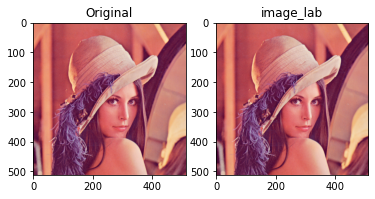

In [2]:
image = cv2.imread('../data/Lena.png')
image_copy = np.copy(image)

###################################################
print_image('Original','image',image,0,2,0,8)
print_image('image_copy','image_copy',image_copy,0,2,0,8)

plt.figure(figsize=(4,6))
plt_view_image(plt,[['Original', image[:,:,[2,1,0]]],
                    ["image_lab",image_copy[:,:,[2,1,0]]]],
               figsize=(6,6), axis='on', cmap='gray' 
              )

In [3]:
seeds = np.full(image.shape[0:2], 0, np.int32)
image_segmentation = np.full(image.shape, 0, np.uint8)

#################################################
print_image('seeds','seeds',seeds,0,2,0,8)
print_image('image_segmentation','image_segmentation',image_segmentation,0,2,0,8)

------  seeds--------------------    Shape(512, 512) seeds: int32
[ 0 0 0 0 0 0 0 0 ]
[ 0 0 0 0 0 0 0 0 ]
------  image_segmentation-------    Shape(512, 512, 3) image_segmentation: uint8
[ [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] ]
[ [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] ]


In [4]:
n_seeds = 9

colors = []
for m in range(n_seeds):
    colors.append((255 * m / n_seeds, randint(0, 255), randint(0, 255)))

print("len(colors) =={0}\ncolors==\n{1}".format(len(colors),colors))

len(colors) ==9
colors==
[(0.0, 14, 24), (28.333333333333332, 208, 3), (56.666666666666664, 213, 136), (85.0, 105, 95), (113.33333333333333, 236, 121), (141.66666666666666, 121, 102), (170.0, 93, 25), (198.33333333333334, 251, 129), (226.66666666666666, 105, 25)]


In [5]:
mouse_pressed = False
current_seed = 1
seeds_updated = False

def mouse_callback(event, x, y, flags, param):
    global mouse_pressed, seeds_updated

    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        cv2.circle(seeds, (x, y), 5, (current_seed), cv2.FILLED)
        cv2.circle(image_copy, (x, y), 5, colors[current_seed - 1], cv2.FILLED)
        seeds_updated = True

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            cv2.circle(seeds, (x, y), 5, (current_seed), cv2.FILLED)
            cv2.circle(image_copy, (x, y), 5, colors[current_seed - 1], cv2.FILLED)
            seeds_updated = True

    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False

------  Original-----------------    Shape(512, 512, 3) image: uint8
[ [125 137 226] [125 137 226] [133 137 223] [128 136 223] [120 138 226] [116 129 226] [123 138 228] [124 134 227] [127 140 227] [119 136 225] [126 135 228] [121 134 225] [108 130 223] [119 139 226] [120 135 223] ]
[ [125 137 226] [125 137 226] [133 137 223] [128 136 223] [120 138 226] [116 129 226] [123 138 228] [124 134 227] [127 140 227] [119 136 225] [126 135 228] [121 134 225] [108 130 223] [119 139 226] [120 135 223] ]
------  image_segmentation-------    Shape(512, 512, 3) image_segmentation: uint8
[ [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] [0 0 0] ]
[ [0 0 0] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] [ 0 14 24] ]
------  image_copy---------------    Shape(512, 512, 3) image_copy: uint8
[ [125 137 226] [125 137 226] [133 137 223] [128 136 223]

<Figure size 720x216 with 0 Axes>

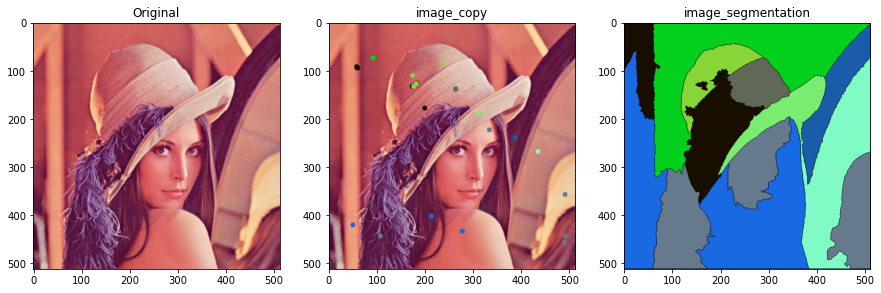

In [6]:
#      Watershed Алгоритм обработки изображений предназначен для отделения объектов на изображении от фона. Алгоритм принимает 
#  изображение в градациях серого и изображения маркера. Маркеры являются изображением, где вы указываете алгоритму 
#  Watershed объекты переднего плана и фон
#cv::watershed(
#  InputArray image - Input 8 bit 3-channel image
#  InputOutputArray markers - Input/output 32-bit single-channel image of markers. it should have the same size as the input


cv2.namedWindow('Working_image C=Clear, #-[0-9]')
cv2.setMouseCallback('Working_image C=Clear, #-[0-9]', mouse_callback)

while True:
    cv2.imshow('image_segmentation', image_segmentation)
    cv2.imshow('Working_image C=Clear, #-[0-9]', image_copy)
        
    k = cv2.waitKey(1)

    if k == 27: # <- Exit
        break
    elif k == ord('c'): # <- Clear
        image_copy = np.copy(image)
        seeds = np.full(image.shape[0:2], 0, np.int32)
        image_segmentation = np.full(image.shape, 0, np.uint8)
    elif k > 0 and chr(k).isdigit():
        n = int(chr(k))
        if 1 <= n <= n_seeds and not mouse_pressed:
            current_seed = n
    
    if seeds_updated and not mouse_pressed:        
        seeds_copy = np.copy(seeds)
        cv2.watershed(image, seeds_copy)
        image_segmentation = np.full(image.shape, 0, np.uint8)
        for m in range(n_seeds):
            image_segmentation[seeds_copy == (m + 1)] = colors[m]
        seeds_updated = False

cv2.destroyAllWindows()




####################################################
print_image('Original','image',image,0,2,0,15)
print_image('image_segmentation','image_segmentation',image_segmentation,0,2,0,15)
print_image('image_copy','image_copy',image_copy,0,2,0,15)

plt.figure(figsize=(10,3))
plt_view_image(plt,[['Original', image[:,:,[2,1,0]]],
                    ['image_copy', image_copy[:,:,[2,1,0]]],
                    ["image_segmentation",image_segmentation[:,:,[2,1,0]]]
                   ],
               figsize=(15,6), axis='on', cmap='gray'
              )

cv2.imshow('Original, image_copy, image_segmentation', 
           np.hstack((image, image_copy, image_segmentation)))
cv2.waitKey()
cv2.destroyAllWindows()